This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
model_x = set_x     

merged_set_f = [[set_y[i],model_x[i][:-1]] for i in range(len(set_y))] # added [:-1] to exclude last visit
merged_set =[x for x in merged_set_f if len(x[1])>0]
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print(test_sh_L[0])
print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[4000, 2016, 244, 1022, 1348, 673, 4900, 127, 2799, 156, 212, 196, 158, 333, 74, 22, 23, 6, 808, 111, 7, 214, 190, 31, 34, 8, 192, 10, 43, 44, 48, 61, 62, 63]]]
model is LR
[0, [[3480, 109, 62, 85], [1724, 401, 3480, 109, 62, 85], [145, 432, 593, 1327, 57, 129, 3480, 109, 62, 85], [145, 432, 2929, 272, 119, 1089, 2419, 1724, 401, 3488, 673, 57, 277, 3480, 258, 886, 196, 158, 22, 550, 6, 189, 26, 111, 7, 308, 190, 31, 8, 10, 1120, 43, 173, 356, 357, 1102, 109, 62, 85]]]
[0, [[119, 454, 83, 62, 85], [2660, 119, 124, 83, 62, 85], [793, 475, 83, 62, 85], [475, 83, 62, 85], [475, 83, 62, 85], [475, 83, 62, 85]]]
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [773, 379, 62, 63, 1518, 665, 379, 62, 63, 665, 379, 62, 63, 1752, 319, 989, 665, 2448, 588, 379, 62, 63, 773, 379, 62, 63, 514, 503, 945, 244, 5085, 526, 773, 153, 3975, 12, 476, 19

In [6]:
print(len(merged_set))

35708


Parameter containing:
-1.0362e+00 -1.3558e-01
 2.1460e+00 -2.5106e-01
-3.1816e-01  2.4988e-01
           ⋮            
 2.0762e+00  2.9017e+00
-3.1476e-01  5.3052e-01
-4.1422e-01  7.7517e-01
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0 -1.036214 -0.135578                            Code
1  2.146010 -0.251064  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -0.318156  0.249881         b'M_BACITRACIN TOPICAL'
3  0.391136 -0.426807    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.819745  0.327262                  b'M_CEFAZOLIN'


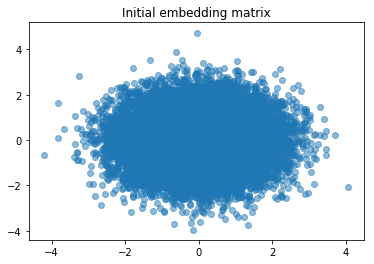

In [7]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [8]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [9]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 1.0717341319507605


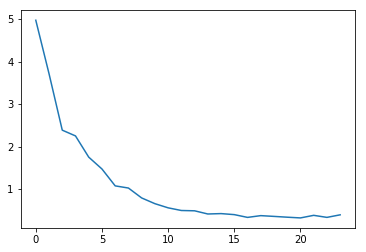

Epoch  0 Summary:  Training_auc : 0.5153176364181298  , Validation_auc :  0.5371902326348786  ,Test_auc :  0.5280893550462293 Test_auc on short visits: 0.5342299543600608 Test_auc on long visits: 0.5132263892011755  Avg Loss:  1.0717341319507605 Train Time (0m 43s) Eval Time (0m 32s)


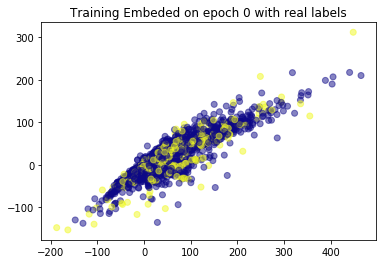

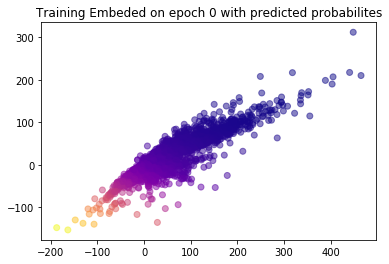


 Current running on: Epoch  1 Training loss:  Average loss 0.34026177518789885


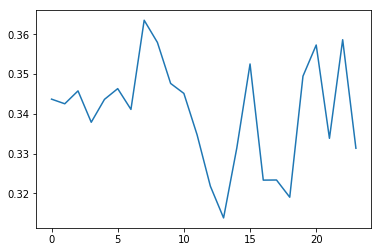

Epoch  1 Summary:  Training_auc : 0.7313480141263676  , Validation_auc :  0.7309833360831546  ,Test_auc :  0.7372348204484254 Test_auc on short visits: 0.7206402891462811 Test_auc on long visits: 0.7480294936306473  Avg Loss:  0.34026177518789885 Train Time (0m 46s) Eval Time (0m 31s)


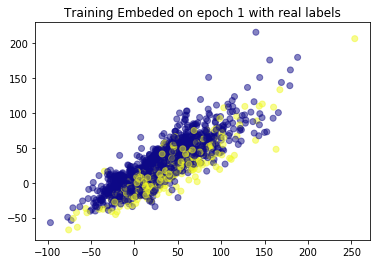

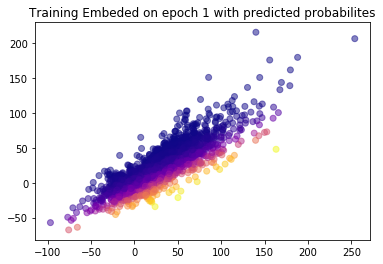


 Current running on: Epoch  2 Training loss:  Average loss 0.32455797523830016


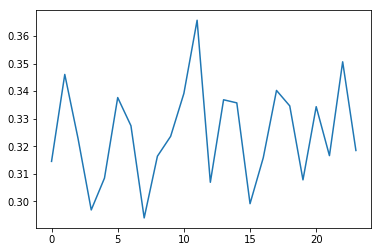

Epoch  2 Summary:  Training_auc : 0.7719272776861518  , Validation_auc :  0.7669081009734368  ,Test_auc :  0.7703776314010287 Test_auc on short visits: 0.7648808134922488 Test_auc on long visits: 0.7796976721947841  Avg Loss:  0.32455797523830016 Train Time (0m 51s) Eval Time (0m 33s)


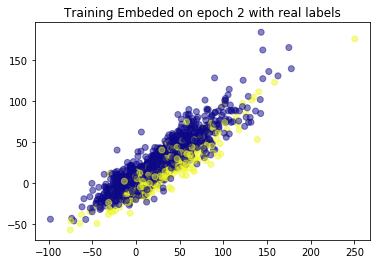

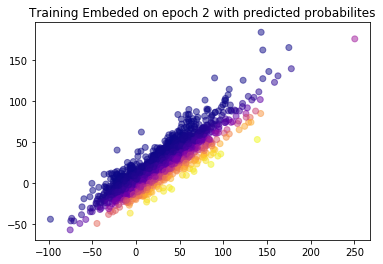


 Current running on: Epoch  3 Training loss:  Average loss 0.319513180682249


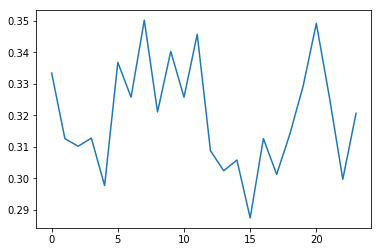

Epoch  3 Summary:  Training_auc : 0.7747429071495185  , Validation_auc :  0.7748630589011715  ,Test_auc :  0.7686118785688025 Test_auc on short visits: 0.7630514825980232 Test_auc on long visits: 0.7779120825160042  Avg Loss:  0.319513180682249 Train Time (0m 52s) Eval Time (0m 34s)


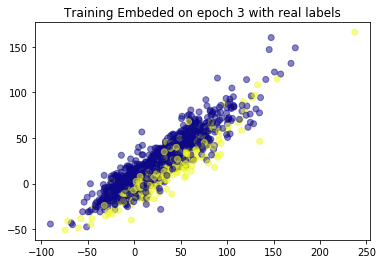

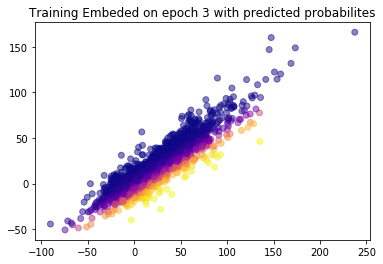


 Current running on: Epoch  4 Training loss:  Average loss 0.3167875776671676


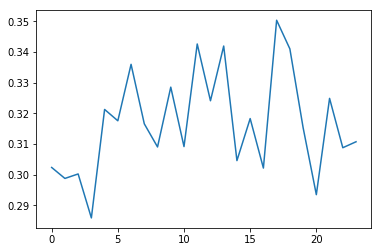

Epoch  4 Summary:  Training_auc : 0.7667912891549092  , Validation_auc :  0.7573519221250619  ,Test_auc :  0.7524306689876027 Test_auc on short visits: 0.7584239054347928 Test_auc on long visits: 0.7573355456140759  Avg Loss:  0.3167875776671676 Train Time (0m 47s) Eval Time (0m 30s)


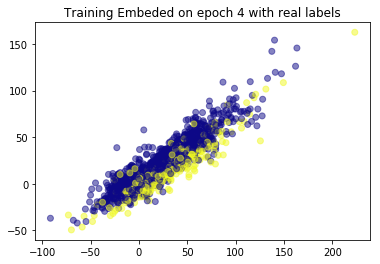

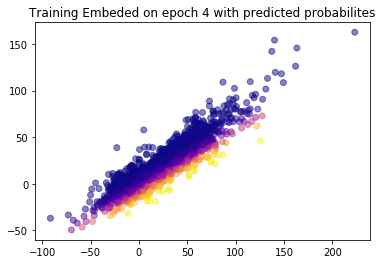


 Current running on: Epoch  5 Training loss:  Average loss 0.3165881445425333


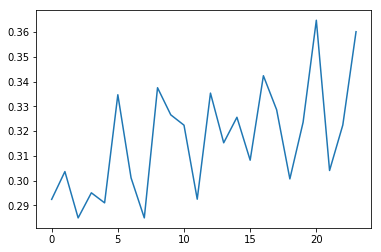

Epoch  5 Summary:  Training_auc : 0.7849195052269662  , Validation_auc :  0.7762572182808117  ,Test_auc :  0.7673662317208589 Test_auc on short visits: 0.7618066509244654 Test_auc on long visits: 0.7778089633552236  Avg Loss:  0.3165881445425333 Train Time (0m 49s) Eval Time (0m 31s)


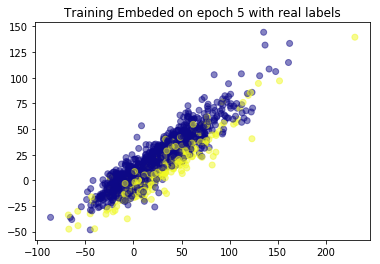

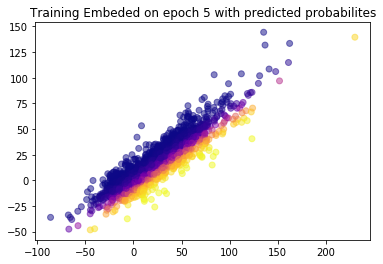


 Current running on: Epoch  6 Training loss:  Average loss 0.31634486881526996


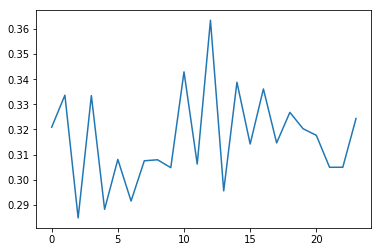

Epoch  6 Summary:  Training_auc : 0.7823244948861235  , Validation_auc :  0.7718091074080183  ,Test_auc :  0.7683731978816555 Test_auc on short visits: 0.76620264506314 Test_auc on long visits: 0.776979874964787  Avg Loss:  0.31634486881526996 Train Time (0m 50s) Eval Time (0m 32s)


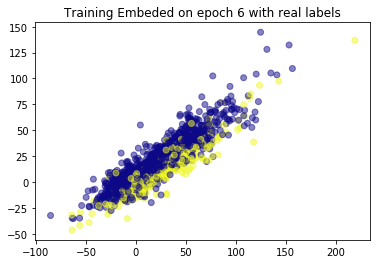

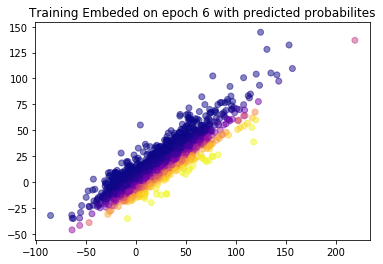


 Current running on: Epoch  7 Training loss:  Average loss 0.31469649092065005


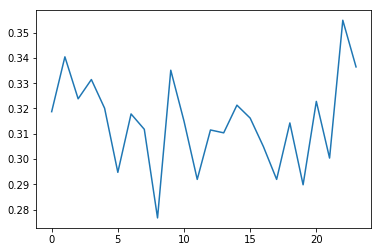

Epoch  7 Summary:  Training_auc : 0.7887123660317168  , Validation_auc :  0.7863504372215806  ,Test_auc :  0.7769603013392566 Test_auc on short visits: 0.7585843218875707 Test_auc on long visits: 0.7898591738578711  Avg Loss:  0.31469649092065005 Train Time (0m 51s) Eval Time (0m 33s)


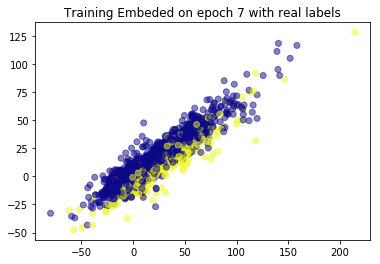

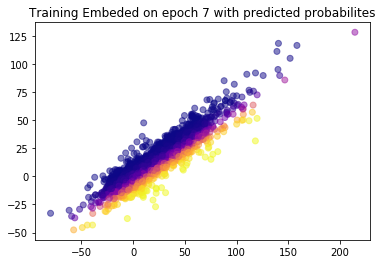


 Current running on: Epoch  8 Training loss:  Average loss 0.31412636168587094


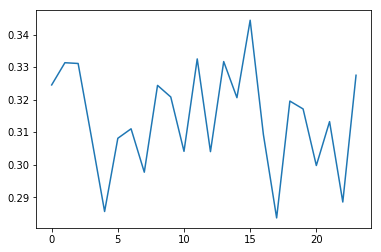

Epoch  8 Summary:  Training_auc : 0.7896193134282329  , Validation_auc :  0.7719245999010065  ,Test_auc :  0.7804028721397896 Test_auc on short visits: 0.7671079771893637 Test_auc on long visits: 0.795844737175362  Avg Loss:  0.31412636168587094 Train Time (0m 50s) Eval Time (0m 32s)


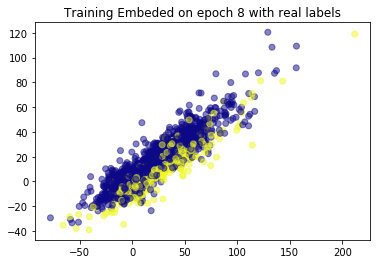

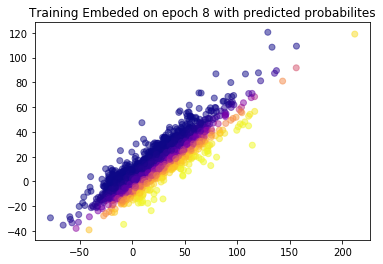


 Current running on: Epoch  9 Training loss:  Average loss 0.31305793279783994


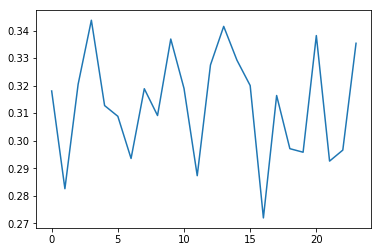

Epoch  9 Summary:  Training_auc : 0.7886409148756783  , Validation_auc :  0.7815574987625805  ,Test_auc :  0.7746618705786336 Test_auc on short visits: 0.7611072351903531 Test_auc on long visits: 0.7901413947189551  Avg Loss:  0.31305793279783994 Train Time (1m 24s) Eval Time (0m 51s)


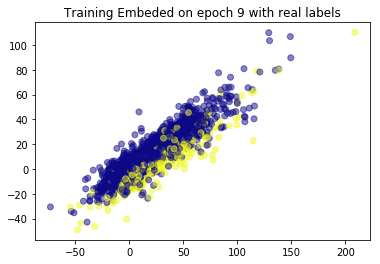

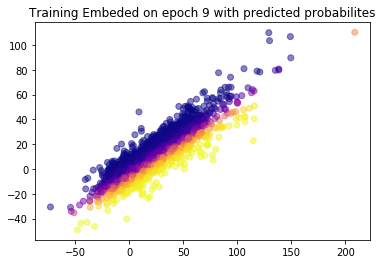


 Current running on: Epoch  10 Training loss:  Average loss 0.31271778046553655


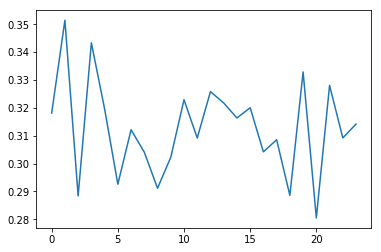

Epoch  10 Summary:  Training_auc : 0.7932894630530328  , Validation_auc :  0.7791577297475664  ,Test_auc :  0.7761066197711421 Test_auc on short visits: 0.7625229833026889 Test_auc on long visits: 0.7926782811405652  Avg Loss:  0.31271778046553655 Train Time (0m 55s) Eval Time (0m 33s)


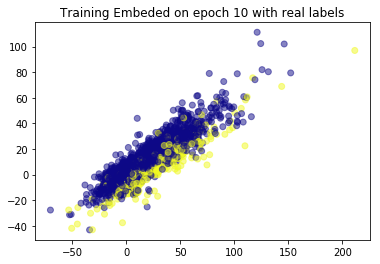

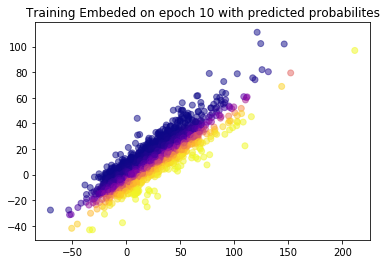


 Current running on: Epoch  11 Training loss:  Average loss 0.312777087666678


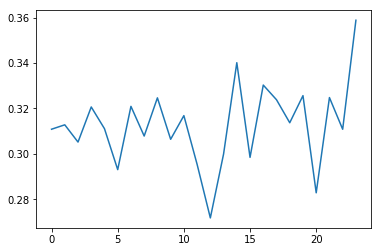

Epoch  11 Summary:  Training_auc : 0.7882121106718505  , Validation_auc :  0.7684152780069295  ,Test_auc :  0.7705319403743423 Test_auc on short visits: 0.7602736529684627 Test_auc on long visits: 0.7825769969322696  Avg Loss:  0.312777087666678 Train Time (0m 48s) Eval Time (0m 34s)


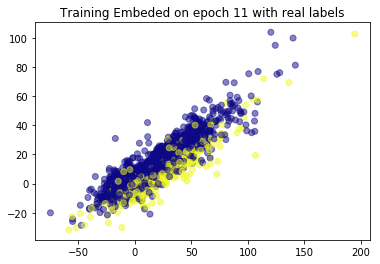

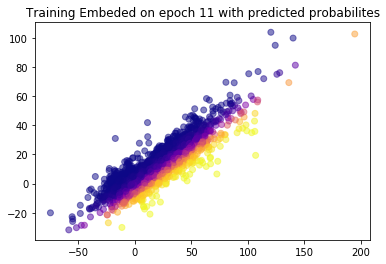


 Current running on: Epoch  12 Training loss:  Average loss 0.3130553700473331


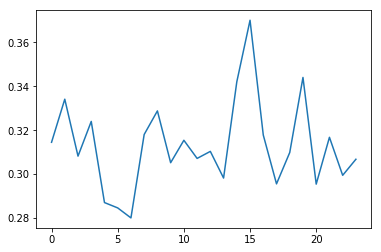

Epoch  12 Summary:  Training_auc : 0.7869247578069244  , Validation_auc :  0.7591354561953473  ,Test_auc :  0.7699525134389427 Test_auc on short visits: 0.7664453114062514 Test_auc on long visits: 0.7794823883328036  Avg Loss:  0.3130553700473331 Train Time (0m 51s) Eval Time (0m 33s)


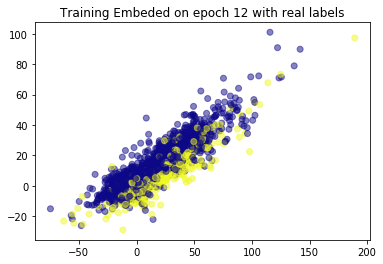

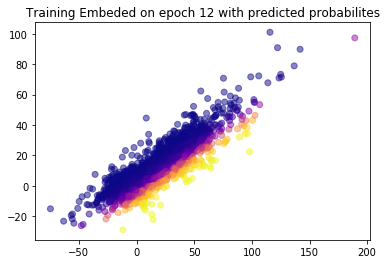


 Current running on: Epoch  13 Training loss:  Average loss 0.3129018051046652


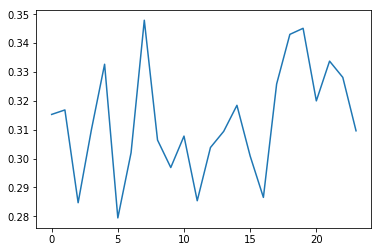

Epoch  13 Summary:  Training_auc : 0.7709251296285272  , Validation_auc :  0.7630366276192049  ,Test_auc :  0.7519467888274716 Test_auc on short visits: 0.7483725021699971 Test_auc on long visits: 0.7591115728644124  Avg Loss:  0.3129018051046652 Train Time (0m 47s) Eval Time (0m 39s)


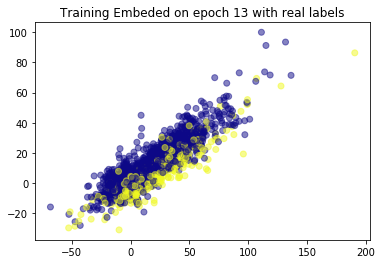

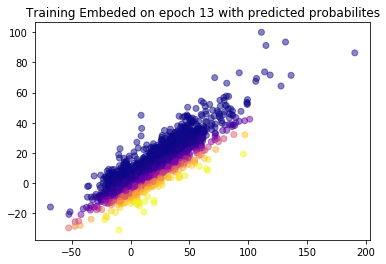


 Current running on: Epoch  14 Training loss:  Average loss 0.3146519480193591


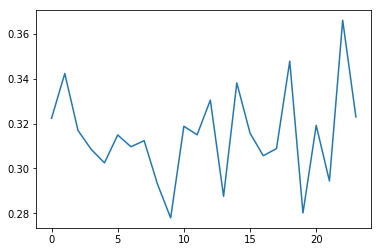

Epoch  14 Summary:  Training_auc : 0.785493797439839  , Validation_auc :  0.7703324533905295  ,Test_auc :  0.7659120768516425 Test_auc on short visits: 0.7633571488571348 Test_auc on long visits: 0.7773349770372495  Avg Loss:  0.3146519480193591 Train Time (1m 34s) Eval Time (0m 53s)


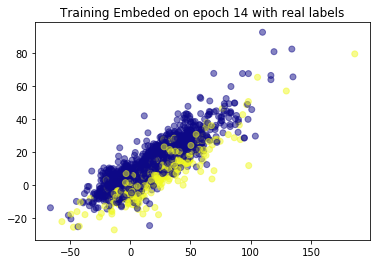

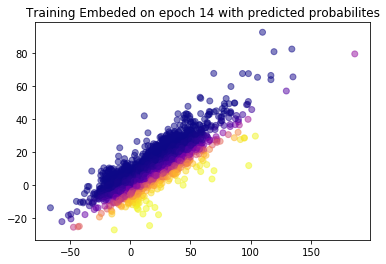


 Current running on: Epoch  15 Training loss:  Average loss 0.3119652759786857


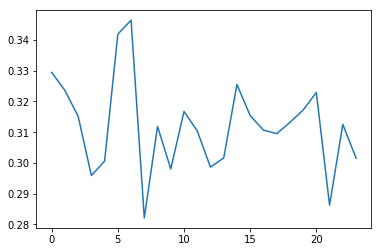

Epoch  15 Summary:  Training_auc : 0.7826396094796741  , Validation_auc :  0.7662902161359512  ,Test_auc :  0.762514299422361 Test_auc on short visits: 0.7564364914180115 Test_auc on long visits: 0.77005047411554  Avg Loss:  0.3119652759786857 Train Time (0m 57s) Eval Time (0m 33s)


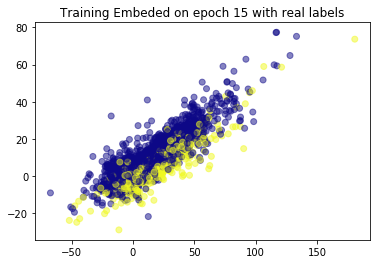

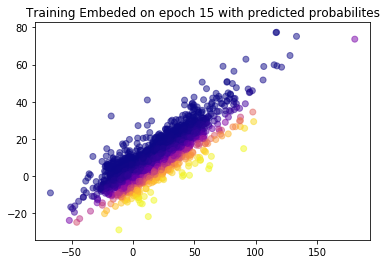


 Current running on: Epoch  16 Training loss:  Average loss 0.31268684227460536


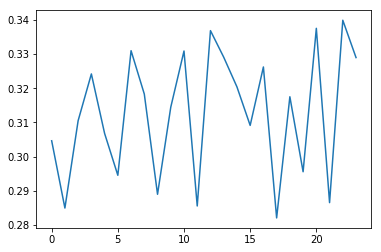

Epoch  16 Summary:  Training_auc : 0.7651161465897915  , Validation_auc :  0.7340018148820329  ,Test_auc :  0.7396383899120484 Test_auc on short visits: 0.7484425020766639 Test_auc on long visits: 0.7430177473503028  Avg Loss:  0.31268684227460536 Train Time (0m 49s) Eval Time (0m 32s)


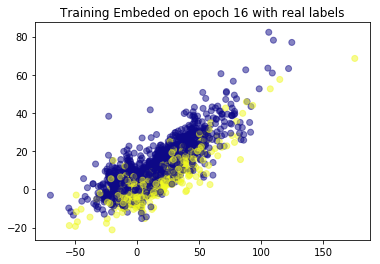

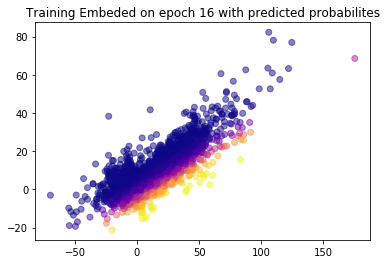


 Current running on: Epoch  17 Training loss:  Average loss 0.3140367210073223


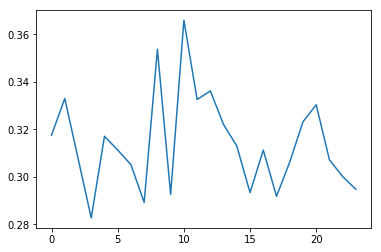

Epoch  17 Summary:  Training_auc : 0.7816684330462382  , Validation_auc :  0.7621477478963866  ,Test_auc :  0.7566875292646922 Test_auc on short visits: 0.7578009062654584 Test_auc on long visits: 0.7631329616908441  Avg Loss:  0.3140367210073223 Train Time (0m 44s) Eval Time (0m 30s)


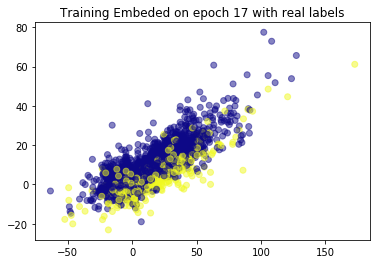

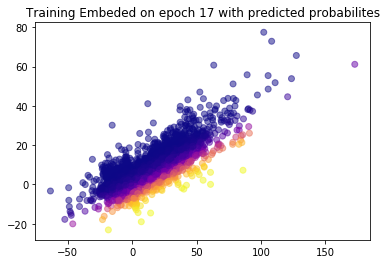


 Current running on: Epoch  18 Training loss:  Average loss 0.31159841195067156


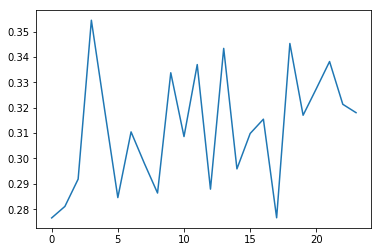

Epoch  18 Summary:  Training_auc : 0.7941384470670382  , Validation_auc :  0.7812341197822142  ,Test_auc :  0.7767207825225018 Test_auc on short visits: 0.7632194823740236 Test_auc on long visits: 0.7912738963794578  Avg Loss:  0.31159841195067156 Train Time (0m 45s) Eval Time (0m 31s)


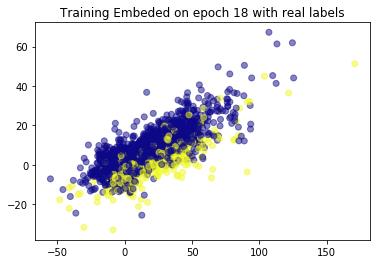

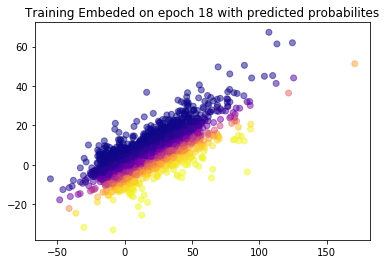


 Current running on: Epoch  19 Training loss:  Average loss 0.31191584960784374


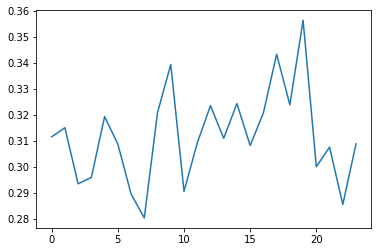

Epoch  19 Summary:  Training_auc : 0.7835293243001564  , Validation_auc :  0.765732552384095  ,Test_auc :  0.7637333123738848 Test_auc on short visits: 0.7606003191995744 Test_auc on long visits: 0.7701429970718293  Avg Loss:  0.31191584960784374 Train Time (0m 52s) Eval Time (0m 34s)


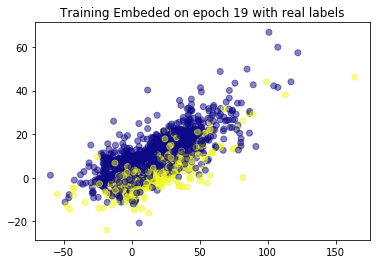

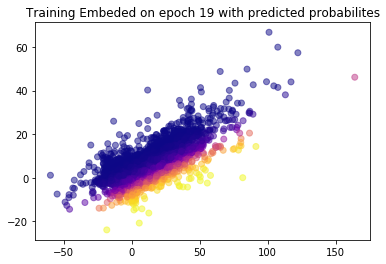

In [10]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

In [11]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

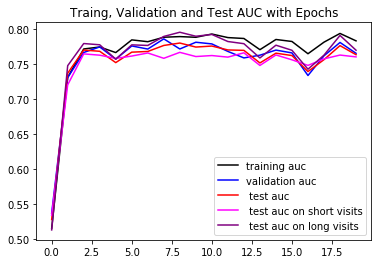

In [12]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [13]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_Original_ExcLast_Dim2')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

In [14]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
